In [24]:
import pandas as pd
import numpy as np

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, plot_confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import seaborn as sns


from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec



from utils.utils import *

In [26]:
# load the whole embedding into memory
# w2v_embeddings_index={}
# TOTAL_EMBEDDING_DIM=100
# embeddings_file='full_grams_cbow_100_wiki.mdl'
# w2v_model =KeyedVectors.load(embeddings_file)
# for word in w2v_model.wv.vocab:
#     w2v_embeddings_index[word] = w2v_model[word]
    
# print('Loaded %s word vectors.'% len(w2v_embeddings_index))

# Reading Data

In [27]:
data = pd.read_csv('full_data.csv')
data.head()

,dialect,txt
0,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. حيونه ووحشيه .. وتطلبون من الغرب يحترمكم ويؤمن بدينكم ولاينعتكم بالإرهاب ..
2,IQ,@KanaanRema مبين من كلامه خليجي
3,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


# Preprocessing

In [28]:
data.txt.sample(3,random_state=5)

109133    رحً ناكل خرا بريحة الجماعه ..\nعده بطلع قائد عرص بيحشر طيزه !\n#جولان
10932                        @LoLoaliaa346 @mahmdh57 اي والله مابيهم اليحجي صدگ
224136       @y_0990 شكرا  على كل  حرف  قلتيه  وياريت كل الناس  تتعلم منك وتفهم
Name: txt, dtype: object

In [29]:
data.txt = data.txt.apply(preprocessing)

In [30]:
data.txt.sample(3,random_state=5)

109133    رح ناكل خرا بريحه الجماعه  عده بطلع قائد عرص بيحشر طيزه  جولان
10932                                            والله مابيهم اليحجي صدگ
224136                   شكرا  حرف  قلتيه  وياريت الناس  تتعلم منك وتفهم
Name: txt, dtype: object

# splitting to train_valid_test sets

In [37]:
le = LabelEncoder()
data['dialect'] = le.fit_transform(data['dialect'])
data['dialect']

0         4
1         4
2         4
3         4
4         4
         ..
458192    1
458193    1
458194    1
458195    1
458196    1
Name: dialect, Length: 458197, dtype: int64

In [38]:
data['dialect'].value_counts()

3     57636
11    43742
6     42109
8     36499
12    31069
5     27921
7     27617
13    26832
0     26296
1     26292
10    19116
15    16242
2     16183
4     15497
14    14434
9     11539
17     9927
16     9246
Name: dialect, dtype: int64

# Tokenization

In [39]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(data['txt']))

In [40]:
###### huge number of stop words 
sorted(x_tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)

[('والله', 24718),
 ('هه', 21266),
 ('شي', 19577),
 ('الي', 14772),
 ('يعني', 13824),
 ('الناس', 13401),
 ('عشان', 13352),
 ('علي', 12770),
 ('مو', 11935),
 ('ده', 10998),
 ('انه', 10330),
 ('يوم', 9868),
 ('شو', 9643),
 ('دي', 9220),
 ('وين', 8583),
 ('ايه', 8497),
 ('احنا', 8458),
 ('ليش', 8456),
 ('الا', 8234),
 ('لازم', 7985),
 ('حد', 7816),
 ('في', 7499),
 ('ناس', 7470),
 ('اللي', 7252),
 ('يارب', 7204),
 ('وانا', 7085),
 ('مره', 6941),
 ('زي', 6827),
 ('اني', 6818),
 ('ممكن', 6664),
 ('اليوم', 6614),
 ('حاجه', 6473),
 ('كنت', 6415),
 ('ربي', 6396),
 ('بس', 6250),
 ('انك', 6202),
 ('عم', 6051),
 ('شاء', 5799),
 ('خير', 5671),
 ('انو', 5657),
 ('مين', 5609),
 ('يكون', 5591),
 ('انتي', 5582),
 ('عندي', 5520),
 ('صح', 5473),
 ('اول', 5287),
 ('هيك', 5189),
 ('وانت', 5155),
 ('كده', 5126),
 ('شنو', 5115),
 ('سنه', 5041),
 ('طيب', 5026),
 ('جدا', 4931),
 ('ليه', 4881),
 ('لان', 4872),
 ('الله', 4817),
 ('كتير', 4787),
 ('قال', 4753),
 ('ربنا', 4573),
 ('مصر', 4552),
 ('فيك', 4537),
 ('

In [41]:
sorted(x_tokenizer.word_counts.items(), key=lambda x:x[1])

[('ولاينعتكم', 1),
 ('الفرضخليجي', 1),
 ('بقدسيتك', 1),
 ('بجنسيت', 1),
 ('ورجحت', 1),
 ('لكوهين', 1),
 ('جحيمه', 1),
 ('مارضين', 1),
 ('بخيرنه', 1),
 ('ولاتنصح', 1),
 ('بالمنصور', 1),
 ('سلڤيات', 1),
 ('ميغلط', 1),
 ('خبلتوها', 1),
 ('اتهمبل', 1),
 ('ينقدها', 1),
 ('اتجوزن', 1),
 ('اللواگه', 1),
 ('شيحبون', 1),
 ('ولافن', 1),
 ('ولاثقافه', 1),
 ('ولامطبقين', 1),
 ('للحوزه', 1),
 ('اخيته', 1),
 ('ياعراقبعدين', 1),
 ('اوزنوا', 1),
 ('تنسبوا', 1),
 ('وناسنه', 1),
 ('وفخرنه', 1),
 ('ترفلون', 1),
 ('اتلومني', 1),
 ('طالعتنه', 1),
 ('سولفينه', 1),
 ('گرايب', 1),
 ('النگد', 1),
 ('مامنزله', 1),
 ('ولاشكلي', 1),
 ('لاتسوينه', 1),
 ('شخسران', 1),
 ('الخايبات', 1),
 ('لفزعاته', 1),
 ('ومامقصوده', 1),
 ('مخضر', 1),
 ('لاتشير', 1),
 ('متاخذغير', 1),
 ('انجمد', 1),
 ('والباگله', 1),
 ('اللوگيه', 1),
 ('تتباري', 1),
 ('نقود', 1),
 ('بالظروره', 1),
 ('عاجزان', 1),
 ('ففضل', 1),
 ('لايوفقچ', 1),
 ('بالجان', 1),
 ('ايڤون', 1),
 ('گدامك', 1),
 ('صدوگ', 1),
 ('ديزيدون', 1),
 ('مينگصون', 1),
 ('مسوانه', 

In [42]:
body_count = []
for sent in data['txt']:
    body_count.append(len(sent.split()))

(array([1.78170e+05, 1.48214e+05, 7.14180e+04, 3.14910e+04, 1.18070e+04,
        8.77700e+03, 6.75900e+03, 1.51700e+03, 4.10000e+01, 3.00000e+00]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <BarContainer object of 10 artists>)

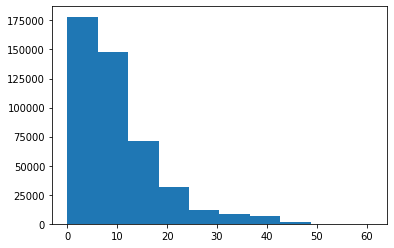

In [43]:
import matplotlib.pyplot as plt

plt.hist(body_count)

In [44]:
#Check how much % of txt have 0-50 words
cnt=0
for i in data['txt']:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(data['txt']))

0.9927738505489997


In [45]:
max_text_len=40


In [46]:


text=[]
dialect=[]
for i in range(len(data)):
    if(len(data.txt[i].split())<=max_text_len):
        text.append(data.txt[i])
        dialect.append(data.dialect[i])
        
post_pre=pd.DataFrame({'text':text,'dialect':dialect})

In [47]:
len(data), 10000/len(data)

(458197, 0.021824673666567002)

In [48]:
# get train and test sets
xtrain,xtest,ytrain,ytest=train_test_split(post_pre['text'],post_pre['dialect'],test_size=0.02,random_state=45,shuffle=True, stratify = post_pre['dialect'])

In [49]:
len(xtrain),10000/len(xtrain)

(445788, 0.022432187497195978)

In [50]:
xtrain,xvalid,ytrain,yvalid=train_test_split(xtrain,ytrain,test_size=0.02,random_state=45,shuffle=True,stratify = ytrain)

In [51]:
thresh=8

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.02547376018849
Total Coverage of rare words: 13.921580669929401


In [52]:
# max_text_len = 40
#prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(xtrain))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(xtrain) 
x_val_seq   =   x_tokenizer.texts_to_sequences(xvalid)
x_test_seq  =   x_tokenizer.texts_to_sequences(xtest)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test   =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')


#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

vocab_size = len(x_tokenizer.word_index)+1

Size of vocabulary in X = 57163


In [53]:
# create a weight matrix for words in training docs
# embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))
# for word, i in x_tokenizer.word_index.items():    
#     embedding_vector = w2v_embeddings_index.get(word)
#     if embedding_vector is not None:        
#         embedding_matrix[i] = embedding_vector
# print('Embedding Matrix shape:', embedding_matrix.shape)


In [54]:
# weights= np.load('full_grams_cbow_100_wiki.mdl.wv.vectors.npy')
# weights = weights[:x_voc,:]

In [60]:

print("Size of vocabulary from the w2v model = {}".format(x_voc))

# # K.clear_session()

embedding_dim=100
# # Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(vocab_size, embedding_dim,
                    #  weights=[embedding_matrix],
                    #  keras.initializers.Constant(),
                     trainable=True, mask_zero=False)(encoder_inputs)

encoder_lstm1 = LSTM(64,return_sequences=False,return_state=False,dropout=0.2)
encoder_output1= encoder_lstm1(enc_emb)
d1 = Dense(32,activation='relu')(encoder_output1)
# d2 = Dense(32,activation='relu')(d1)

output = Dense(18,activation='softmax')(d1)

model = Model(encoder_inputs, output)
model.summary()

Size of vocabulary from the w2v model = 57163
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 40, 100)           42338300  
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 18)                594       
                                                                 
Total params: 42,383,214
Trainable params: 42,383,214
Non-trainable params: 0
_________________________________________________________________


In [61]:
# inp = Input(shape=(max_text_len,))
# embedding_dim=100
# latent_dim = 200
 
# model = Embedding(input_dim=vocab_size,
#                     output_dim=embedding_dim,
#                     trainable=True,
#                     weights=[embedding_matrix]
#                     )(inp)
# model = LSTM(units=latent_dim, return_sequences=True, return_state=False)(model)
# # model = Dropout(0.3)(model)

# model = LSTM(units=latent_dim//2, return_sequences=False, return_state=False)(model)
# model = Dropout(0.3)(model)
    
# model = Flatten()(model)
    
# # model = Dense(64, activation='relu')(model)
# # model = Dropout(0.3)(model)

# model = Dense(18, activation='softmax')(model)
# model = Model(inputs=inp, outputs=model)
# model.summary()


In [62]:
# inp = Input(shape=(max_text_len,))
# embedding_dim=100
# latent_dim = 64
 
# model = Embedding(input_dim=vocab_size,
#                     output_dim=embedding_dim,
#                     trainable=True,
#                     weights=[embedding_matrix]
#                     )(inp)
# model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
# model = Dropout(0.3)(model)
# model = MaxPooling1D(pool_size=2)(model)
# model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
# model = MaxPooling1D(pool_size=2)(model)
# model = Flatten()(model)
# model = Dropout(0.3)(model)
# model = Dense(latent_dim, activation='relu')(model)
# model = Dropout(0.3)(model)
# model = Dense(18, activation='softmax')(model)
# model = Model(inputs=inp, outputs=model)
# model.summary()


In [63]:
# opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
chkpt =ModelCheckpoint('best.h5', monitor="val_loss",verbose=0,save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss", 
    patience = 5,
    verbose = 1, 
    factor = 0.1, 
    min_lr = 0.00000001,
)


history=model.fit(x_tr, ytrain,epochs=200,callbacks=[es,chkpt,reduce_lr],batch_size=512, validation_data=(x_val, yvalid))

Epoch 1/200
 34/854 [>.............................] - ETA: 6:22 - loss: 2.8453 - accuracy: 0.1097

KeyboardInterrupt: 

In [88]:
from keras.models import load_model 

model = load_model('best.h5')

In [89]:
preds = model.predict(x_test)
preds = np.argmax(preds,axis=-1)
accuracy_score(ytest, preds)

0.4724554847219169

In [100]:
f1_score(ytest,preds,average='macro')

0.4295318840727351

In [90]:
out= le.inverse_transform(preds)
orig = le.inverse_transform(ytest)

<AxesSubplot:>

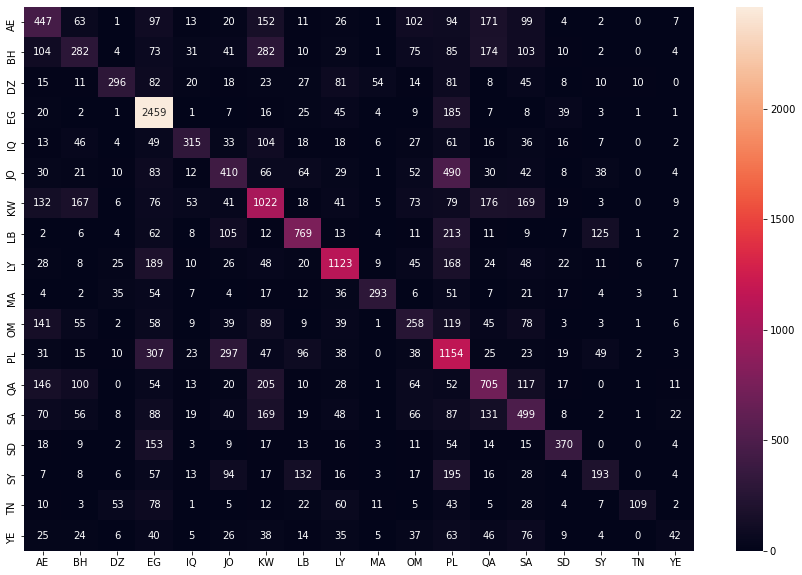

In [91]:

cnf_matrix = confusion_matrix(ytest,preds)
plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix,xticklabels=le.classes_,annot=True,fmt='g', yticklabels=le.classes_)

In [92]:
print(classification_report(ytest,preds))


              precision    recall  f1-score   support

           0       0.36      0.34      0.35      1310
           1       0.32      0.22      0.26      1310
           2       0.63      0.37      0.46       803
           3       0.61      0.87      0.71      2833
           4       0.57      0.41      0.47       771
           5       0.33      0.29      0.31      1390
           6       0.44      0.49      0.46      2089
           7       0.60      0.56      0.58      1364
           8       0.65      0.62      0.63      1817
           9       0.73      0.51      0.60       574
          10       0.28      0.27      0.28       955
          11       0.35      0.53      0.42      2177
          12       0.44      0.46      0.45      1544
          13       0.35      0.37      0.36      1334
          14       0.63      0.52      0.57       711
          15       0.42      0.24      0.30       810
          16       0.81      0.24      0.37       458
          17       0.32    

<AxesSubplot:>

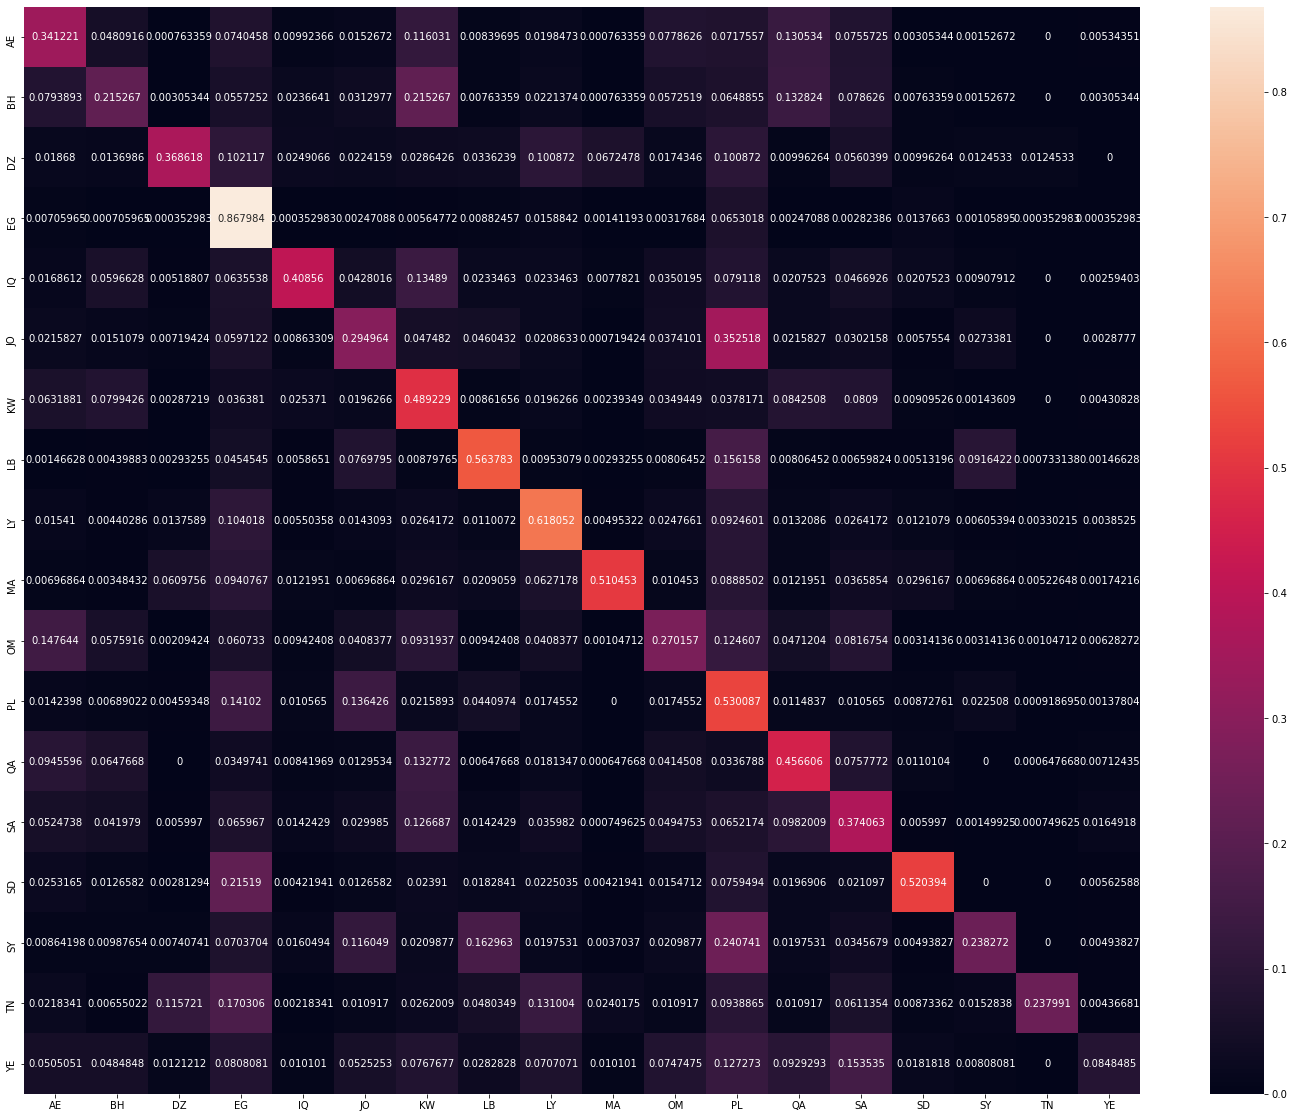

In [93]:
matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(25,20))

sns.heatmap(matrix,xticklabels=le.classes_,annot=True,fmt='g', yticklabels=le.classes_)

<AxesSubplot:ylabel='count'>

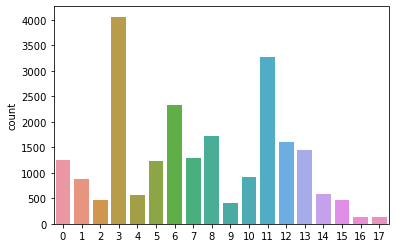

In [97]:
sns.countplot(preds)

<AxesSubplot:xlabel='dialect', ylabel='count'>

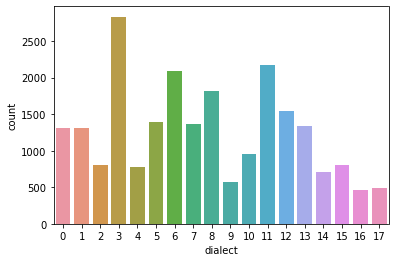

In [98]:
sns.countplot(ytest)